<a href="https://colab.research.google.com/github/Tamrika/Deep-Learning/blob/main/Median_house_value_Prediction_GeneralizedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Implementing the Learning Algorithm

### 1.1 Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### 1.2 Parameter Initialization

In [ ]:
"""
nx is the number of neurons in the input layer (i.e., the number of features in the dataset)
nh is the number of neurons in the hidden layer 
ny is the number of neurons in the output layer (For this example we are using one nueron in the output layer so ny=1)
"""
def initialize_parameters(nx,nh,ny):
    #set the random seed so the same random values are generated every time you run this function
    np.random.seed(12345)

    parameters = {}
    #initialize weights to small random numbers and biases to zeros for each layer
    
    # Input Layer
    W1=(2*np.random.rand(nh[0],nx)-1)*0.01
    b1=np.zeros((nh[0],1))
    parameters.update({'W1' : W1, 'b1' : b1})
    
    # Hidden Layers (if more than one)
    if (len(nh) != 1):
        for index in range(0, len(nh) - 1):
            curr = str(index + 2)
            factor1 = random.uniform(1.5, 2)
            factor2 = 0.01 #random.uniform(0.01, 0.02)
            parameters['W' + curr] = factor1*np.random.rand(nh[index + 1], nh[index])*factor2
            parameters['b' + curr] = np.zeros((nh[index + 1],1))
    
    # Output Layer
    WO=np.random.rand(ny,nh[-1])*0.01
    bO=np.zeros((ny,1))
    parameters.update({'WO' : WO, 'bO' : bO})
    
    return parameters

### 1.3 Forward Pass

In [ ]:
#relu activation
def relu(z):
    return np.maximum(0,z)

#leakyrelu
def leakyrelu(Z, alpha):
	return np.maximum(alpha * Z, Z)
 
#sigmoid activation
def sigmoid(z):
    a= 1/(1+np.exp(-z))
    return a


In [ ]:
"""
In forward pass we do the computations in the computational graph. We cache the intermediate nodes we will later need in the backward pass
"""
def forward_pass(parameters,X):
    
    cache = {}
    
    # Assuming the activation function between all hidden layers is relu
    leaky_alpha = 0.01
    
    # First Layer
    Z= np.dot(parameters["W1"],X)+parameters["b1"]
    A=leakyrelu(Z, leaky_alpha)
    
    # Update first layer
    cache.update({'A1' : A, 'Z1' : Z})
    
    nh = int((len(parameters) / 2) - 1)
    
    # Hidden Layers (if more than one)
    if (nh > 1):
        for index in range(0, nh - 1):
            curr = str(index + 2)

            Z=np.dot(parameters["W" + curr],A)+parameters["b" + curr]
            A=leakyrelu(Z, leaky_alpha)
            cache.update({'A' + curr : A, 'Z' + curr : Z})
    
    # Output Layer
    Z=np.dot(parameters["WO"],A)+parameters["bO"]
    Yhat=Z
    
    cache['ZO'] = Z
    
    return Yhat,cache


Let's also write a utility method to compute the loss

In [ ]:
"""
n is the number of examples, y is a vector of actual/observed outputs and yhat is a vector of predicted outputs

Mean Squared Error - For Regression

""" 
def compute_loss(Y,Yhat):
   
    n=Y.shape[1]
    loss= np.square(np.subtract(Y, Yhat)).mean(axis= 1) 
    return loss


### 1.3 Backward Pass

In [ ]:
'''
Y is the observed output and Yhat is the predicted output (i.e., output of the network)
The derivative of Mean Squared Error with respect to Yhat is (Yhat-Y)
'''
def dMSELoss(Y,Yhat):
    return (Yhat-Y) 


'''
The derivative of sigmoid(A) with respect to A is A*(1-A) 
where * is elementwise multiplication 
'''
def dsigmoid(Z):
    A=sigmoid(Z)
    return (A*(1-A))


def drelu(Z):
    """
np.where(condition, x, y) for each element of the array returns x if condition is true otherwise returns y.
In this case for each element Z drelu=1 if the element is greater than 0 otherwise drelu=0
"""
    drelu=np.where(Z>0, 1.0, 0.0) 
    return drelu 

def dleakyrelu(Z, alpha):
    return np.where(Z>0, 1.0, alpha)


In [ ]:
def backward_pass(parameters, cache, X, Y, Yhat):
    
    leaky_alpha = 0.01

    n=X.shape[1]
    nh = int((len(parameters) / 2) - 1)
    gradients = {}
    
    # Start backwards from output layer...
    dZO=dMSELoss(𝑌,Yhat)
    
    dWO=(1/n)*np.dot(dZO,cache["A" + str(nh)].T)
    dbO=(1/n)*np.sum(dZO, axis=1, keepdims=True)
    gradients.update({'dWO' : dWO, 'dbO' : dbO})
    
    dA=np.dot(parameters["WO"].T,dZO)
    
    # Hidden Layers (if more than one)
    if (nh > 1):
        for index in reversed(range(0, nh - 1)):
            curr = str(index + 2)
            prev = str(index + 1)

            dZ=dA*dleakyrelu(cache['Z' + curr], leaky_alpha)
            dW=(1/n)*np.dot(dZ,cache["A" + prev].T)
            db=(1/n)*np.sum(dZ, axis=1, keepdims=True)
            dA=np.dot(parameters["W" + curr].T, dZ)
            gradients.update({'dW' + curr : dW, 'db' + curr : db})
            
    # .. to the input layer
    dZ1=dA*dleakyrelu(cache["Z1"], leaky_alpha)
    dW1=(1/n)*np.dot(dZ1,X.T)
    db1=(1/n)*np.sum(dZ1, axis=1, keepdims=True)
    gradients.update({'dW1' : dW1, 'db1' : db1})
    
    return gradients
    
    

### 1.4 Using Gradient Descent To update the parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    
    identifiers = set([x[1] for x in parameters.keys()])
    
    for idt in identifiers:
        parameters['W' + idt]=parameters['W' + idt]-learning_rate*gradients['dW' + idt]
    
    return parameters

### 1.5 Putting it all together, Creating the NN Model

In [ ]:
"""
Arguments: train_X: is the training dataset (features)
           train_Y: is the vector of labels for training_X
           val_X: is the vector of validation dataset (features)
           val_y: is the vector of labels for val_X
           nh: is a list of numbers, denoting number of neurons in each  of neurons in the hidden layer
           num_iterations: The number of iterations of gradient descent
"""
def create_nn_model(train_X,train_Y,nh, val_X, val_Y, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding. 
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """ 
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples" 
    assert(len(nh) >= 1), "Need at least one hidden layer"

    
    #getting the number of features
    nx=train_X.shape[0]
    
    # We want to use this network for regression, so we have only one neuron in the output layer with a no activation
    ny=1
    
    # initializing the parameteres
    parameters=initialize_parameters(nx,nh,ny)
    
    
    #initialize lists to store the training and valideation losses for each iteration. 
    val_loss=[]
    train_loss=[]
    
    #run num_iterations of gradient descent
    for i in range (0, num_iterations):
        #run the forward pass on train_X
        Yhat_train, train_cache= forward_pass(parameters,train_X)
        
        #run the forward pass on val_X
        Yhat_val,val_cache= forward_pass(parameters,val_X)
        
        #compute the loss on the train and val datasets
        train_loss.append(compute_loss(train_Y,Yhat_train))
        val_loss.append(compute_loss(val_Y,Yhat_val))

        
        """
        run the backward pass. Note that the backward pass is only run on the training data not the validation data
        Because the learning must be only done on the training data and hence, validation data is not used to update
        the model parameters.  
        """
        gradients=backward_pass(parameters, train_cache, train_X, train_Y,Yhat_train)
        
        
        # update the parameters
        parameters=update_parameters(parameters, gradients, learning_rate)
        
        #print the trianing loss and validation loss for each iteration.
        print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss[i],val_loss[i]))
        
    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_loss,
             "train_loss": train_loss}
        
        
        #return the parameters and the history
    return parameters, history
        
        
    
    

## 2. Applying the NN model to predict California Housing Prices

In [ ]:
# reading the input datasets train.csv and validation.csv and store them into numpy arrays
train=pd.read_csv("sample_data/california_housing_train.csv")
val = pd.read_csv("sample_data/california_housing_test.csv")
print(train.shape)
print(val.shape)

(17000, 9)
(3000, 9)


Splitting training data further in to training and validation test for hyperparameter tuning.

In [ ]:
val_train = train.sample(frac= 0.2, random_state= 12345)
train = train[~train.index.isin(val_train.index)]

print(train.shape)
print(val_train.shape)
print(val.shape)

(13600, 9)
(3400, 9)
(3000, 9)


In [ ]:
train = train.to_numpy()
val_train = val_train.to_numpy()
val = val.to_numpy()

train_X=train[:,:-1]
train_Y=train[:,-1]
train_Y=np.reshape(train_Y, (1,train_Y.size))

val_train_X=val_train[:,:-1]
val_train_Y=val_train[:,-1]
val_train_Y=np.reshape(val_train_Y, (1,val_train_Y.size))

val_X=val[:,:-1]
val_Y=val[:,-1]
val_Y=np.reshape(val_Y, (1,val_Y.size))

print(train_X.shape)
print(val_train_X.shape)
print(val_X.shape)

print(train_Y.shape)
print(val_train_Y.shape)
print(val_Y.shape)

(13600, 8)
(3400, 8)
(3000, 8)
(1, 13600)
(1, 3400)
(1, 3000)


### Normalizing the features

In [ ]:
def normalizeFeatures(input):
  return ((input - input.mean(axis= 0)) / input.std(axis=0))

def scaleTarget(input):
  return np.divide(input, 100000)

train_X = normalizeFeatures(train_X)
val_train_X = normalizeFeatures(val_train_X)
val_X = normalizeFeatures(val_X)

train_Y = scaleTarget(train_Y)
val_train_Y = scaleTarget(val_train_Y)
val_Y = scaleTarget(val_Y)


### Training the Neural Network

In [ ]:
iterations=500
parameters, history=create_nn_model(train_X.T,train_Y,[100, 50, 50], val_train_X.T, val_train_Y, iterations, 0.1)

iteration 0 :train_loss:[5.661853] val_loss[5.55173303]
iteration 1 :train_loss:[5.66159518] val_loss[5.55147518]
iteration 2 :train_loss:[5.6613248] val_loss[5.5512048]
iteration 3 :train_loss:[5.6610405] val_loss[5.55092054]
iteration 4 :train_loss:[5.66074083] val_loss[5.55062096]
iteration 5 :train_loss:[5.66042424] val_loss[5.55030448]
iteration 6 :train_loss:[5.66008898] val_loss[5.54996939]
iteration 7 :train_loss:[5.65973325] val_loss[5.54961385]
iteration 8 :train_loss:[5.65935501] val_loss[5.54923583]
iteration 9 :train_loss:[5.65895205] val_loss[5.54883314]
iteration 10 :train_loss:[5.65852195] val_loss[5.54840339]
iteration 11 :train_loss:[5.65806205] val_loss[5.54794392]
iteration 12 :train_loss:[5.65756944] val_loss[5.54745181]
iteration 13 :train_loss:[5.6570409] val_loss[5.54692385]
iteration 14 :train_loss:[5.65647289] val_loss[5.5463565]
iteration 15 :train_loss:[5.65586142] val_loss[5.54574589]
iteration 16 :train_loss:[5.65520221] val_loss[5.54508766]
iteration 17 :

### Train vs Validation Loss

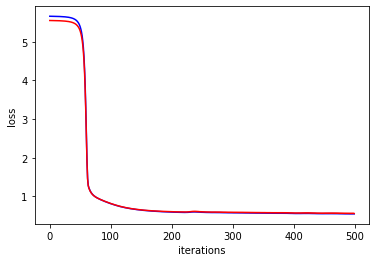

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

### Hyperparameter Tuning

In [ ]:
import random

randomTrials = 5
results = {}

for i in range(0, randomTrials):

  params = {'learning_rate' : random.choice([0.08, 0.1, 0.2]),
            'iterations' : random.choice([1000, 1500, 2000]),
            'neurons' : random.choice([[128, 64, 64, 64], [64, 128], [64, 128, 192], [100, 50]])}

  parameters, history=create_nn_model(train_X.T,train_Y, params['neurons'], val_train_X.T, val_train_Y, params['iterations'], params['learning_rate'])

  results[str(i+1)] = {'learning_rate' : params['learning_rate'], 'neurons' : params['neurons'], 'iterations' : params['iterations'], 'loss' : history['val_loss'][-1]}



Streaming output truncated to the last 5000 lines.
iteration 501 :train_loss:[0.6212992] val_loss[0.66577775]
iteration 502 :train_loss:[0.86953013] val_loss[0.83089226]
iteration 503 :train_loss:[1.07507666] val_loss[1.174427]
iteration 504 :train_loss:[2.55826845] val_loss[2.4595407]
iteration 505 :train_loss:[0.58117427] val_loss[0.57190276]
iteration 506 :train_loss:[0.65386405] val_loss[0.70664638]
iteration 507 :train_loss:[1.01523709] val_loss[0.96477729]
iteration 508 :train_loss:[1.14485382] val_loss[1.25171731]
iteration 509 :train_loss:[2.76353206] val_loss[2.66142238]
iteration 510 :train_loss:[0.6894345] val_loss[0.6633498]
iteration 511 :train_loss:[0.88618504] val_loss[0.96879014]
iteration 512 :train_loss:[1.90364715] val_loss[1.81892857]
iteration 513 :train_loss:[0.65780036] val_loss[0.71020838]
iteration 514 :train_loss:[1.03239636] val_loss[0.98255481]
iteration 515 :train_loss:[1.14371755] val_loss[1.25275939]
iteration 516 :train_loss:[2.756969] val_loss[2.6533979

In [ ]:
resultDF = pd.DataFrame(results).T.sort_values('loss')
resultDF

,learning_rate,neurons,iterations,loss
3,0.08,"[100, 50]",1500,[0.5251245059483746]
1,0.1,"[128, 64, 64, 64]",2000,[0.5265878248670105]
4,0.08,"[64, 128, 192]",1500,[0.5299974511898745]
5,0.2,"[100, 50]",1000,[0.5318748771230088]
2,0.2,"[128, 64, 64, 64]",1500,[0.5334532856451114]


**The combination in the first row of the table above results in the best validation loss.**

### Model Validation

Combine testing and test-validation sets.

In [ ]:
final_train_X = np.concatenate((train_X, val_train_X))
final_train_Y = np.concatenate((train_Y, val_train_Y), axis= 1)
print(final_train_X.shape)
print(final_train_Y.shape)


(17000, 8)
(1, 17000)


In [ ]:
best_params = resultDF.iloc[0]
parameters, history=create_nn_model(final_train_X.T, final_train_Y, best_params['neurons'], val_X.T, val_Y, best_params['iterations'], best_params['learning_rate'])


iteration 0 :train_loss:[5.63693909] val_loss[5.51087908]
iteration 1 :train_loss:[5.63573864] val_loss[5.50967987]
iteration 2 :train_loss:[5.63443929] val_loss[5.50838222]
iteration 3 :train_loss:[5.63301934] val_loss[5.50696459]
iteration 4 :train_loss:[5.63145441] val_loss[5.50540272]
iteration 5 :train_loss:[5.62971694] val_loss[5.50366909]
iteration 6 :train_loss:[5.62777541] val_loss[5.50173225]
iteration 7 :train_loss:[5.62559363] val_loss[5.49955624]
iteration 8 :train_loss:[5.62312991] val_loss[5.49709945]
iteration 9 :train_loss:[5.62033615] val_loss[5.49431393]
iteration 10 :train_loss:[5.61715624] val_loss[5.49114408]
iteration 11 :train_loss:[5.61352431] val_loss[5.48752362]
iteration 12 :train_loss:[5.60936333] val_loss[5.48337624]
iteration 13 :train_loss:[5.60458258] val_loss[5.47861203]
iteration 14 :train_loss:[5.5990742] val_loss[5.47312333]
iteration 15 :train_loss:[5.59271002] val_loss[5.46678288]
iteration 16 :train_loss:[5.58533843] val_loss[5.45943878]
iteratio

### Train vs Validation Loss

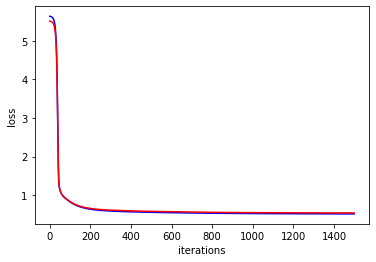

In [ ]:
plt.plot(range(0,best_params['iterations']),history["train_loss"],'b')
plt.plot(range(0,best_params['iterations']),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

### Model Scoring

In [ ]:
def predict(parameters,X):
    Yhat,cache=forward_pass(parameters, X)
    return Yhat

In [ ]:
def MAPE(predictedY, observedY):
    return np.divide(np.abs(np.subtract(observedY, predictedY)), observedY).mean(axis= 1) 


In [ ]:
predicted_val=predict(parameters, val_X.T)

print("Mean Absolute Percentage Error (Validation Data):", MAPE(predicted_val, val_Y) * 100)

Mean Absolute Percentage Error (Validation Data): [32.44625711]


## Conclusion

**The basic single layer neural network performs better than the multi-layer neural network in this case. The multi-layer neural network has a slightly higher Mean Absolute Percentage Error of 32% compared to single layer neural network which has a MAPE of about 27%**